In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

Read the data

In [2]:
df = pd.read_csv("data/TASK-ML-INTERN.csv")

# 1. Data Exploration and Preprocessing

In [3]:
df.head(2)

,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0


Dropping hsi_id feature will keep our data only numerical

In [4]:
# Drop the index feature
df = df.drop(columns=["hsi_id"])

In [5]:
print("data shape:", df.shape)

data shape: (500, 449)


In [6]:
# Check missing values
print("Number of nulls in the data:", df.isnull().sum().sum())

Number of nulls in the data: 0


correlation matrix between spectral features and vomitoxin levels

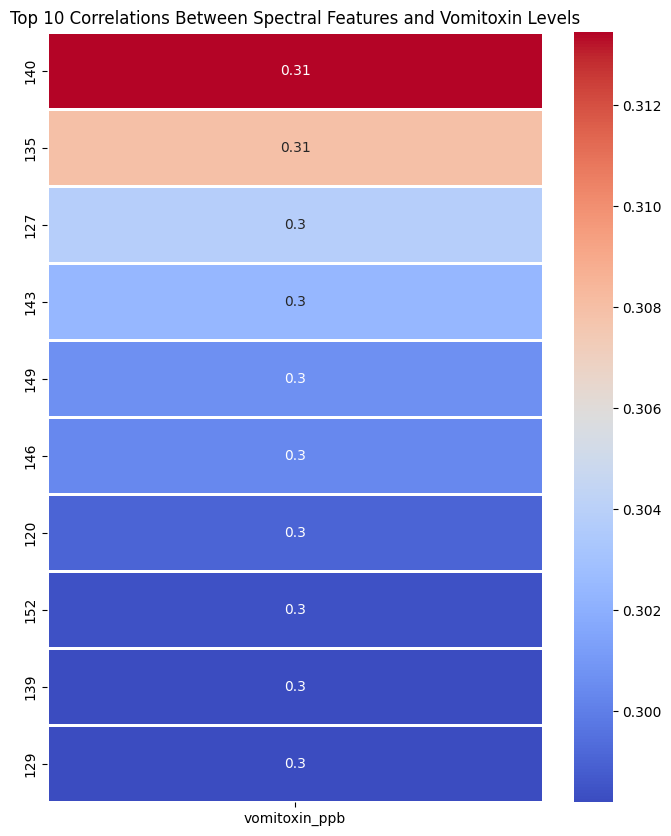

In [7]:
corr = df.corr()
top_features = corr[['vomitoxin_ppb']].abs().sort_values(by='vomitoxin_ppb', ascending=False)[1:11]
plt.figure(figsize=(8, 10))
sns.heatmap(top_features, cmap="coolwarm", annot=True, linewidths=.9)
plt.title("Top 10 Correlations Between Spectral Features and Vomitoxin Levels")
plt.show()

In [8]:
print("Statistics for spectral data: ")
df.describe().T

Statistics for spectral data: 


,count,mean,std,min,25%,50%,75%,max
0,500.0,0.443118,0.044719,0.311182,0.410456,0.449105,0.480245,0.556287
1,500.0,0.440761,0.045520,0.295321,0.404310,0.442651,0.478822,0.530168
2,500.0,0.433814,0.045764,0.284064,0.397038,0.434215,0.473158,0.528774
3,500.0,0.426122,0.046070,0.282054,0.389029,0.425074,0.464947,0.533202
4,500.0,0.418990,0.045405,0.296702,0.382102,0.417075,0.459232,0.511909
...,...,...,...,...,...,...,...,...
444,500.0,0.738738,0.053601,0.571767,0.700638,0.743965,0.775686,0.945225
445,500.0,0.738298,0.054014,0.577803,0.698655,0.743301,0.775621,0.932812
446,500.0,0.737599,0.054136,0.576985,0.698107,0.745216,0.774635,0.931381
447,500.0,0.738099,0.054297,0.562302,0.699673,0.745733,0.774310,0.957860


In [9]:
df["vomitoxin_ppb"].skew()

np.float64(7.225180854841568)

boxplot to highlight outliers

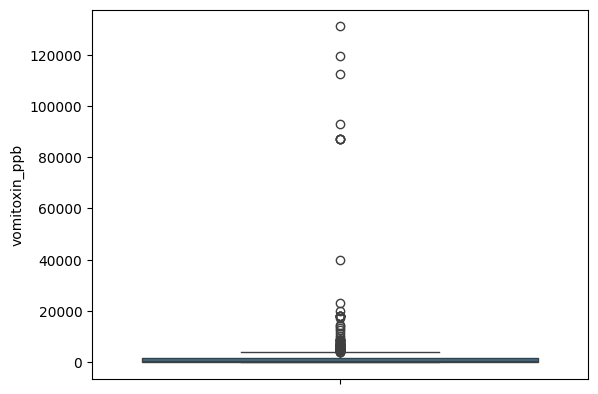

In [10]:
sns.boxplot(y=df["vomitoxin_ppb"])
plt.show()

Let's check take a closer look at distribution of vomitoxin

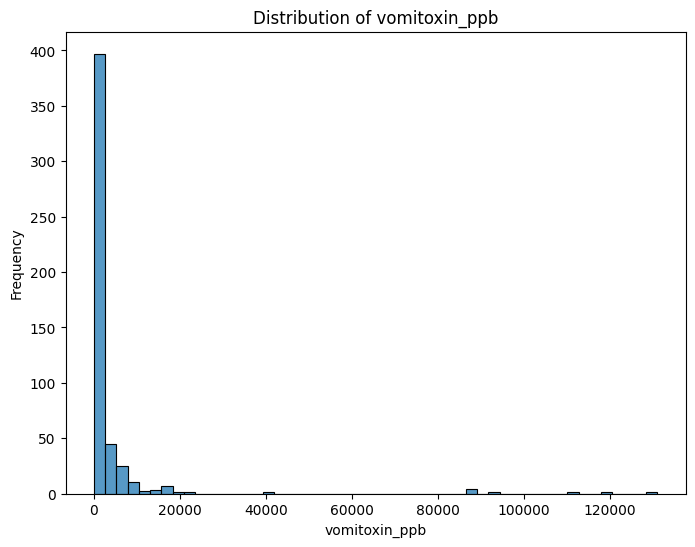

In [11]:
from src.utils import vomitoxin_distribution
vomitoxin_distribution(df, "vomitoxin_ppb")

This skewness can hurt the regression models because of the extreme values.
I will apply log(1 + x) transformation after data splitting

## Summary of EDA
**Feature Range:**
* Most spectral features (0-447) have values between ~0.25 and 0.95
* The target value has a very large range: 0 to 131,000.

**STD**
* Most spectral features have a small standard deviation (~0.04 to 0.05).
* The target has an extremely high standard deviation (13,095.8), indicating extreme outliers.

## Data Preprocessing


Standardization using RobustScaler

In [12]:
# Prepare the data
X = df.drop("vomitoxin_ppb", axis=1)
y = df["vomitoxin_ppb"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Apply log transformation
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)
print("skew after log transform", y_train.skew())

skew after log transform -1.6131337884033525


In [14]:
# Apply robust scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Dimensionality reduction

## PCA

In [15]:
pca = PCA(n_components=10)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

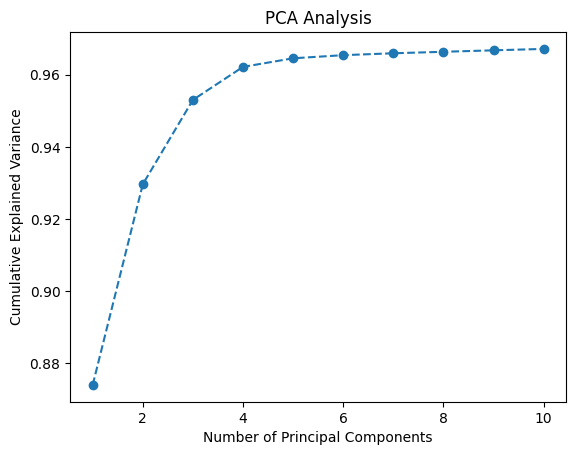

In [16]:
from src.utils import plot_pca_analysis
plot_pca_analysis(pca)

### PCA Analysis Results:
* the first 4 components explain ~95% of the variance
* the first 6 components explain ~97% of the variance
* Additional components do not contribute much new information

**conclusion**: to simplify model and reduce overfitting: we will use 6 components.

In [17]:
# Select the first 4 components
X_train_pca_selected = X_train_pca[:, :6]
X_test_pca_selected = X_test_pca[:, :6]

# Convert PCA results into dataframe
df_pca = pd.DataFrame(X_train_pca_selected)
df_pca.columns = [f"PC{i+1}" for i in range(X_train_pca_selected.shape[1])]
df_pca["vomitoxin_ppb"] = np.expm1(y_train.values)
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,vomitoxin_ppb
0,7.671267,1.525512,-0.854508,0.979615,-0.011654,0.254295,400.0
1,-20.308120,0.143644,0.780318,-0.697959,0.729540,-0.612921,200.0
2,-8.561462,-0.901795,0.312526,1.242381,-1.105548,-0.100691,0.0
3,0.347482,-9.372774,-0.536748,-1.405152,-0.052232,0.080874,100.0
4,4.352678,0.786785,-0.843930,2.375561,0.730435,-0.133023,570.0


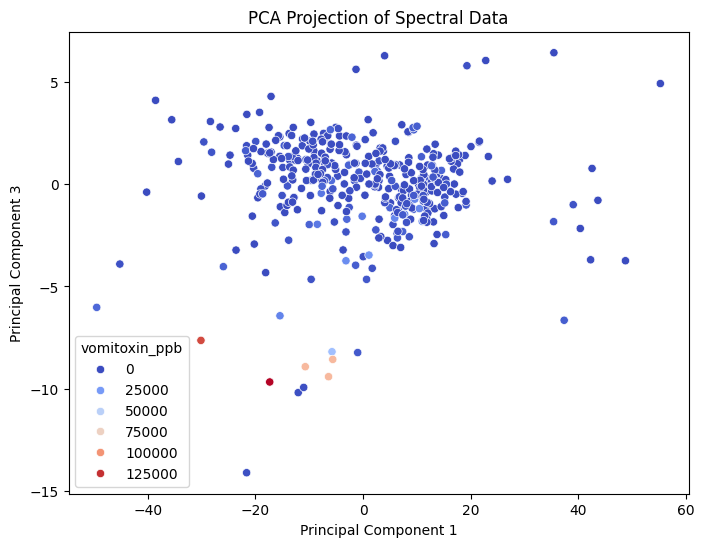

In [18]:
from src.utils import plot_pca_projection
plot_pca_projection(df_pca, 1,3)

high-toxin samples cluster together means PCA successfully captured important patterns.

# 4. Model Training

### Random Forest

In [19]:
# Create a list to store model outputs
outputs = []

In [20]:
from src import modeling

# Random Forest
rf_baseline = modeling.train_baseline_model(X_train_pca_selected, y_train, 'rf')
rf_tuned = modeling.tune_random_forest(X_train_pca_selected, y_train)

# XGBoost
xgb_baseline = modeling.train_baseline_model(X_train_pca_selected, y_train, 'xgb')
xgb_tuned = modeling.tune_xgboost(X_train_pca_selected, y_train)


In [21]:
from src import evaluation

all_predictions = []
results = pd.DataFrame()

for name, model in [
    ('RF Baseline', rf_baseline),
    ('RF Tuned', rf_tuned),
    ('XGB Baseline', xgb_baseline),
    ('XGB Tuned', xgb_tuned)
]:
    # Pass the log_transformed y_test to the function
    metrics = evaluation.evaluate_model(model, X_test_pca_selected, y_test)
    
    results = pd.concat([results, evaluation.log_results({
        "mae": metrics["mae"],
        "rmse": metrics["rmse"],
        "r2": metrics["r2"]
    }, name)])
    
    # Store predictions with original scale values
    all_predictions.append({
        'model': name,
        'y_test': metrics['y_test'],  
        'y_pred': metrics['y_pred']
    })


RF Baseline Results:
MAE: 2763.8504
RMSE: 10383.9987
R²: 0.6143

RF Tuned Results:
MAE: 2857.8622
RMSE: 11263.0071
R²: 0.5462

XGB Baseline Results:
MAE: 2953.3154
RMSE: 9961.0082
R²: 0.6450

XGB Tuned Results:
MAE: 3779.5867
RMSE: 15147.5484
R²: 0.1792



In [22]:
results

,mae,rmse,r2,model_name
0,2763.850360,10383.998668,0.614259,RF Baseline
0,2857.862205,11263.007098,0.546189,RF Tuned
0,2953.315443,9961.008206,0.645045,XGB Baseline
0,3779.586717,15147.548380,0.179173,XGB Tuned


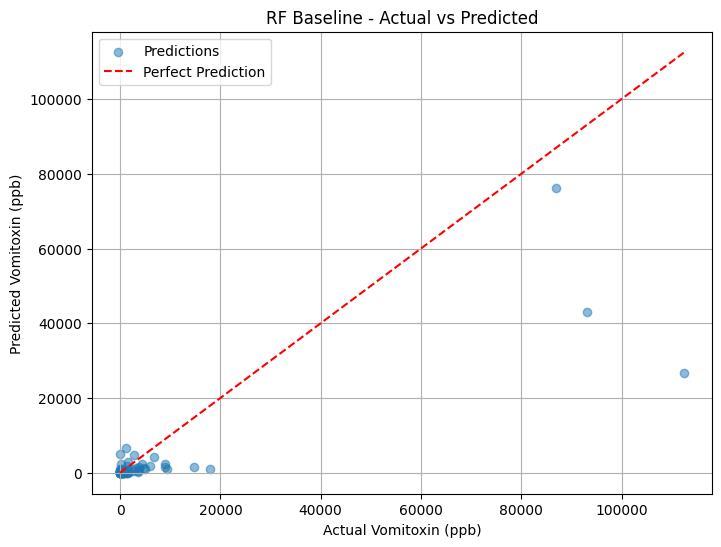

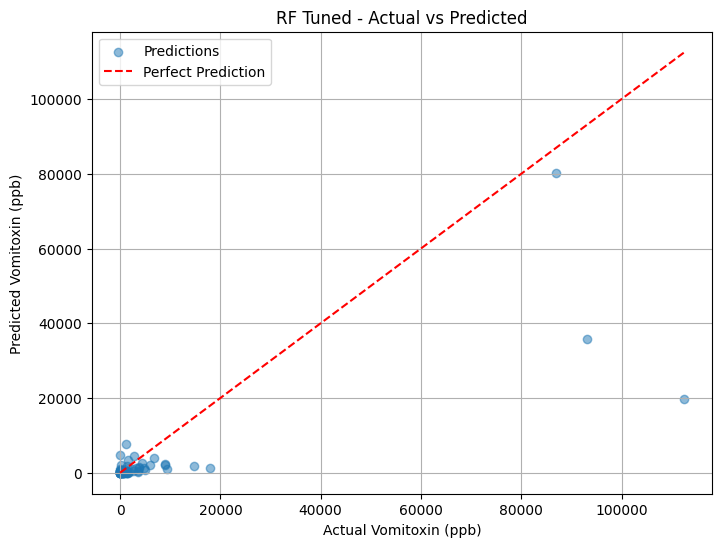

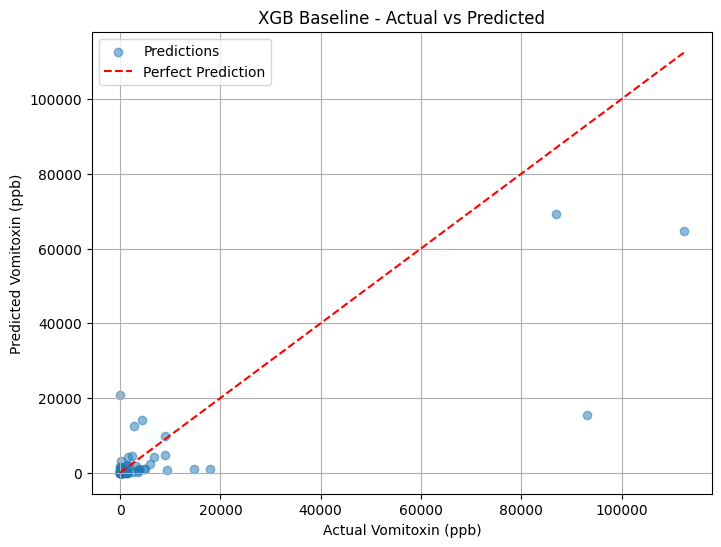

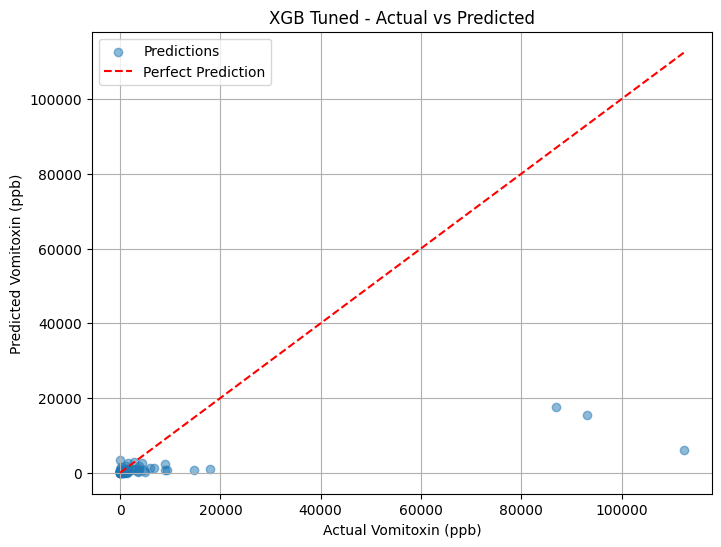

In [23]:
from src.utils import plot_actual_vs_predicted

for pred_data in all_predictions:
    plot_actual_vs_predicted(
        pred_data['y_test'], 
        pred_data['y_pred'],
        pred_data['model']
    )

# 5. Models Evaluation

<Figure size 1000x500 with 0 Axes>

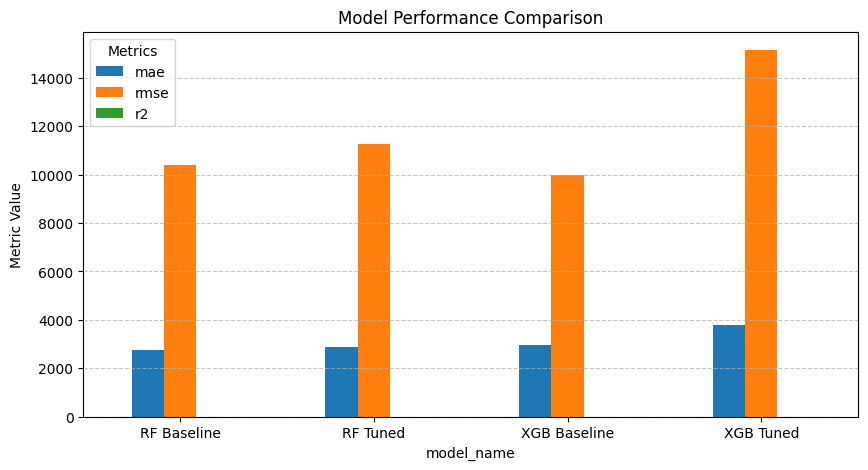

In [24]:
from src.utils import plot_metrics
plot_metrics(results)